In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import random
from glob import glob
import seaborn as sns
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
from PIL import Image
import time
import copy

# visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# # PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision import models
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
# import timm


import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00


# Loading the Data

In [4]:
df = pd.read_csv('/content/drive/My Drive/STAT5243/Project 3/Data/train.csv')
df.shape

# Data Preprocessing

In [6]:
df.rename(columns = {'class':'classes'}, inplace = True)

In [7]:
temp=df["id"].apply(lambda x: x.split("_")).loc[1]
temp

['case123', 'day20', 'slice', '0001']

In [8]:
int(temp[0].replace("case", ""))

123

## Extracting Case, Day, and Slice

In [9]:
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))

In [10]:
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))

In [11]:
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])

In [12]:
df.sample()

,id,classes,segmentation,case,day,slice
24078,case102_day0_slice_0027,large_bowel,NaN,102,0,0027


In [13]:
df.shape

(115488, 6)

## Constructing Image Paths

In [14]:
train_directory='/content/drive/My Drive/STAT5243/Project 3/Data/train'

In [15]:
train_images = glob(os.path.join(train_directory, "**", "*.png"), recursive=True)
x = train_images[0].rsplit("/", 4)[0]

In [16]:
x

'/content/drive/My Drive/STAT5243/Project 3/Data/train'

## Creating Partial Paths

In [17]:
partial_path = []
for i in range(0, df.shape[0]):
    partial_path.append(os.path.join(x,"case"+str(df["case"].values[i]),"case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),"scans","slice_"+str(df["slice"].values[i])))
df["partial_path"] = partial_path

In [18]:
train_images[0]

'/content/drive/My Drive/STAT5243/Project 3/Data/train/case6/case6_day24/scans/slice_0007_360_310_1.50_1.50.png'

In [19]:
train_images[0].rsplit("_", 4)

['/content/drive/My Drive/STAT5243/Project 3/Data/train/case6/case6_day24/scans/slice_0007',
 '360',
 '310',
 '1.50',
 '1.50.png']

In [20]:
partial_path = []
for i in range(0, len(train_images)):
    partial_path.append(str(train_images[i].rsplit("_", 4)[0]))

## Another DataFrame for Merging

In [21]:
temp_df = pd.DataFrame()

In [22]:
temp_df['partial_path'] = partial_path
temp_df['path'] = train_images

## Merging DataFrames

In [23]:
df = df.merge(temp_df, on="partial_path").drop(columns=["partial_path"])

In [24]:
df.sample()

,id,classes,segmentation,case,day,slice,path
101655,case78_day30_slice_0142,large_bowel,NaN,78,30,0142,/content/drive/My Drive/STAT5243/Project 3/Dat...


In [25]:
df.shape

(115488, 7)

In [26]:
df['id'][::3]

,id
0,case123_day20_slice_0001
3,case123_day20_slice_0002
6,case123_day20_slice_0003
9,case123_day20_slice_0004
12,case123_day20_slice_0005
...,...
115473,case30_day0_slice_0140
115476,case30_day0_slice_0141
115479,case30_day0_slice_0142
115482,case30_day0_slice_0143


In [27]:
train_images[0].rsplit("_", 4)

['/content/drive/My Drive/STAT5243/Project 3/Data/train/case6/case6_day24/scans/slice_0007',
 '360',
 '310',
 '1.50',
 '1.50.png']

Here

In [28]:
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))

In [29]:
df['segmentation'].loc[8793]

'29485 5 29749 9 30014 11 30279 13 30545 14 30810 16 31076 17 31342 18 31607 20 31873 21 32139 22 32404 24 32670 24 32936 25 33202 25 33467 26 33733 26 33999 26 34265 25 34531 25 34797 26 35063 26 35329 26 35595 27 35861 28 36128 27 36395 27 36662 26 36928 26 37194 26 37460 26 37726 26 37992 26 38257 26 38523 26 38789 25 39055 25 39321 24 39587 24 39853 23 40119 22 40385 22 40652 20 40918 19 41185 17 41452 15 41719 12 41987 9'

## Final dataframe

In [30]:
train_df = pd.DataFrame({'id': df['id'][::3]})
train_df['large_bowel'] = df['segmentation'][::3].values
train_df['small_bowel'] = df['segmentation'][1::3].values
train_df['stomach'] = df['segmentation'][2::3].values

In [31]:
df.iloc[8793]

,8793
id,case130_day22_slice_0052
classes,large_bowel
segmentation,29485 5 29749 9 30014 11 30279 13 30545 14 308...
case,130
day,22
slice,0052
path,/content/drive/My Drive/STAT5243/Project 3/Dat...
width,266
height,266


In [32]:
train_df.sample()

,id,large_bowel,small_bowel,stomach
89031,case29_day0_slice_0046,NaN,NaN,NaN


In [33]:
train_df['path'] = df['path'][::3].values
train_df['case'] = df['case'][::3].values
train_df['day'] = df['day'][::3].values
train_df['slice'] = df['slice'][::3].values
train_df['width'] = df['width'][::3].values
train_df['height'] = df['height'][::3].values

In [34]:
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height
0,case123_day20_slice_0001,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0001,266,266
3,case123_day20_slice_0002,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0002,266,266
6,case123_day20_slice_0003,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0003,266,266
9,case123_day20_slice_0004,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0004,266,266
12,case123_day20_slice_0005,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0005,266,266


In [35]:
train_df.reset_index(inplace=True, drop=True)

In [36]:
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height
0,case123_day20_slice_0001,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0001,266,266
1,case123_day20_slice_0002,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0002,266,266
2,case123_day20_slice_0003,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0003,266,266
3,case123_day20_slice_0004,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0004,266,266
4,case123_day20_slice_0005,NaN,NaN,NaN,/content/drive/My Drive/STAT5243/Project 3/Dat...,123,20,0005,266,266


In [37]:
train_df.isna().sum()

,0
id,0
large_bowel,24411
small_bowel,27295
stomach,29869
path,0
case,0
day,0
slice,0
width,0
height,0


In [38]:
train_df.fillna('', inplace=True)

In [39]:
train_df.iloc[:, 1:4].sample(5)

,large_bowel,small_bowel,stomach
19488,20096 8 20361 11 20577 3 20626 15 20837 11 208...,21680 4 21945 7 21982 3 22210 9 22247 6 22475 ...,
2589,,,
9146,,,
4985,25733 8 25998 10 26263 12 26528 14 26794 15 27...,,19820 7 19828 1 20084 24 20348 33 20613 40 208...
15454,21433 6 21696 11 21894 6 21959 15 22158 11 222...,23586 5 23849 10 24114 12 24379 14 24632 5 246...,


Here count column computes the number of non-empty segmentation classes

In [40]:
train_df['count'] = np.sum(train_df.iloc[:, 1:4] != '', axis=1).values

# EDA

## No of segments present

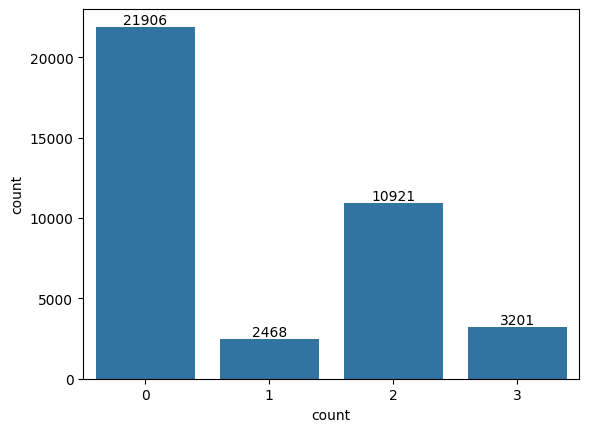

In [41]:
ax=sns.countplot(x='count', data=train_df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')
plt.show()

## count of each class

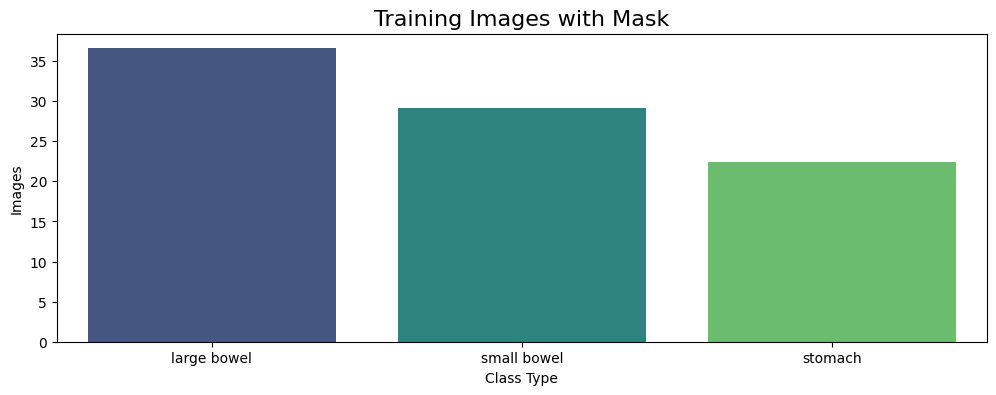

In [42]:
labels = ["large bowel", "small bowel", "stomach"]
values = 100 * np.mean(train_df.iloc[:, 1:4] != '', axis=0)
plt.figure(figsize=(12, 4))
sns.barplot(x=labels, y=values, palette="viridis")
plt.title('Training Images with Mask', fontsize=16)
plt.ylabel('Images')
plt.xlabel('Class Type')
plt.show()

In [43]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

In [44]:
train_df[train_df['large_bowel']!=''].index

Index([   74,    75,    76,    77,    78,    79,    80,    81,    82,    83,
       ...
       38479, 38480, 38481, 38482, 38483, 38484, 38485, 38486, 38487, 38488],
      dtype='int64', length=14085)

In [45]:
train_mask = list(train_df[train_df['large_bowel']!=''].index)
train_mask += list(train_df[train_df['small_bowel']!=''].index)
train_mask += list(train_df[train_df['stomach']!=''].index)

In [46]:
mydf=train_df[train_df.index.isin(train_mask)]

In [47]:
mydf.reset_index(inplace=True,drop=True)

In [48]:
mydf.shape

(16590, 11)

# Validation

## StratifiedGroupKFold

In [49]:
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=mydf, y=mydf['count'],groups =mydf['case']), 1):
    mydf.loc[val_idx, 'fold'] = fold

first fold out of 5 folds go to validation and other are for train

In [50]:
train_ids = mydf[mydf["fold"]!=1].index
validation_ids = mydf[mydf["fold"]==1].index

In [51]:
mydf.groupby('fold').size()

,0
fold,
1.0,3973
2.0,2806
3.0,3656
4.0,3121
5.0,3034


In [52]:
mydf.groupby(['fold','count'])['id'].count()

fold  count
1.0   1         556
      2        2664
      3         753
2.0   1         362
      2        1843
      3         601
3.0   1         607
      2        2348
      3         701
4.0   1         566
      2        2018
      3         537
5.0   1         377
      2        2048
      3         609
Name: id, dtype: int64

# Custom dataset

__init__
whatset: A flag indicating whether this dataset is for training or not ("train" or other values). If set to "train", it will load masks for training; otherwise, it only loads images.<br>
Fixed Image size img_size = (224, 224) <br>

__len__ Returns the total number of samples (rows) in the dataset <br>

Image and Mask Retrieval (__getitem__):

Given an index, it retrieves the corresponding image and, if in training mode, the associated masks.
Loads the image using self.load_image() and applies normalization and resizing.
If whatset is "train", it also loads and decodes segmentation masks with self.load_masks() for training.

In [53]:
class myDataset(Dataset):
    def __init__(self, df, whatset="train", transforms=None):
        self.df = df
        self.whatset = whatset
        self.transforms = transforms
        self.img_size = (224, 224)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image
        img_path = self.df['path'].iloc[index]
        img = self.load_image(img_path)

        # Load masks if in training mode
        if self.whatset == 'train':
            masks = self.load_masks(index)
            return torch.tensor(img), torch.tensor(masks)

        return torch.tensor(img)

    def load_image(self, img_path):
        """Loads and preprocesses an image from a file path."""
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) #normalizes pixel values across the range [0, 255]
        img = cv2.resize(img, self.img_size) # 224,224
        img = np.repeat(img[..., None], 3, axis=-1)  # Convert to 3-channel RGB
        return img.transpose(2, 0, 1).astype(np.float32) / 255.0 # (C, H, W) -> colour and scales pixel values to the range [0, 1]

    def load_masks(self, index):
        """Loads and decodes RLE masks for each class."""
        masks = np.zeros((*self.img_size, 3), dtype=np.float32)  # Initialize empty mask
        #Reads RLE (Run-Length Encoding) mask from the DataFrame.
        for channel, label in enumerate(["large_bowel", "small_bowel", "stomach"]):
            rle = self.df[label].iloc[index]
            mask = rle_decode(rle, shape=(self.df['height'].iloc[index], self.df['width'].iloc[index]))
            mask = cv2.resize(mask, self.img_size)
            masks[:, :, channel] = mask
        return masks.transpose(2, 0, 1)  # Convert to (C, H, W)

## Training transform

 data augmentation or preprocessing that can be applied to images or masks.

In [54]:
train_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.NEAREST),# It resizes and preserves exact class label
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(contrast=0.2),    # RandomContrast equivalent
        transforms.ColorJitter(brightness=0.2)  # RandomBrightness equivalent
    ], p=0.2)
])

## Validation transform

In [55]:
validation_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.NEAREST)
])

## Train and Validation Dataset

Creates a dataset instance for the training set and validation set

In [56]:
train_dataset = myDataset(train_df[train_df.index.isin(train_ids)], transforms=train_transform)
validation_dataset = myDataset(train_df[train_df.index.isin(validation_ids)], transforms=validation_transform)

## DataLoader

in train dataset Each batch contains 32 samples, which are used to update model parameters in each iteration.drop_last=False: Keeps all batches, even if the last batch has fewer than 32 samples. If set to True, it would drop the last, incomplete batch. pin_memory=True increases data transfer speed to gpu
<br>
and in validation dataset each batch contains 64 samples as the model does not update its weights during validation. A larger batch size allows faster validation

In [57]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=64,num_workers=4, shuffle=False, pin_memory=True)

In [58]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

In [59]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')

    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

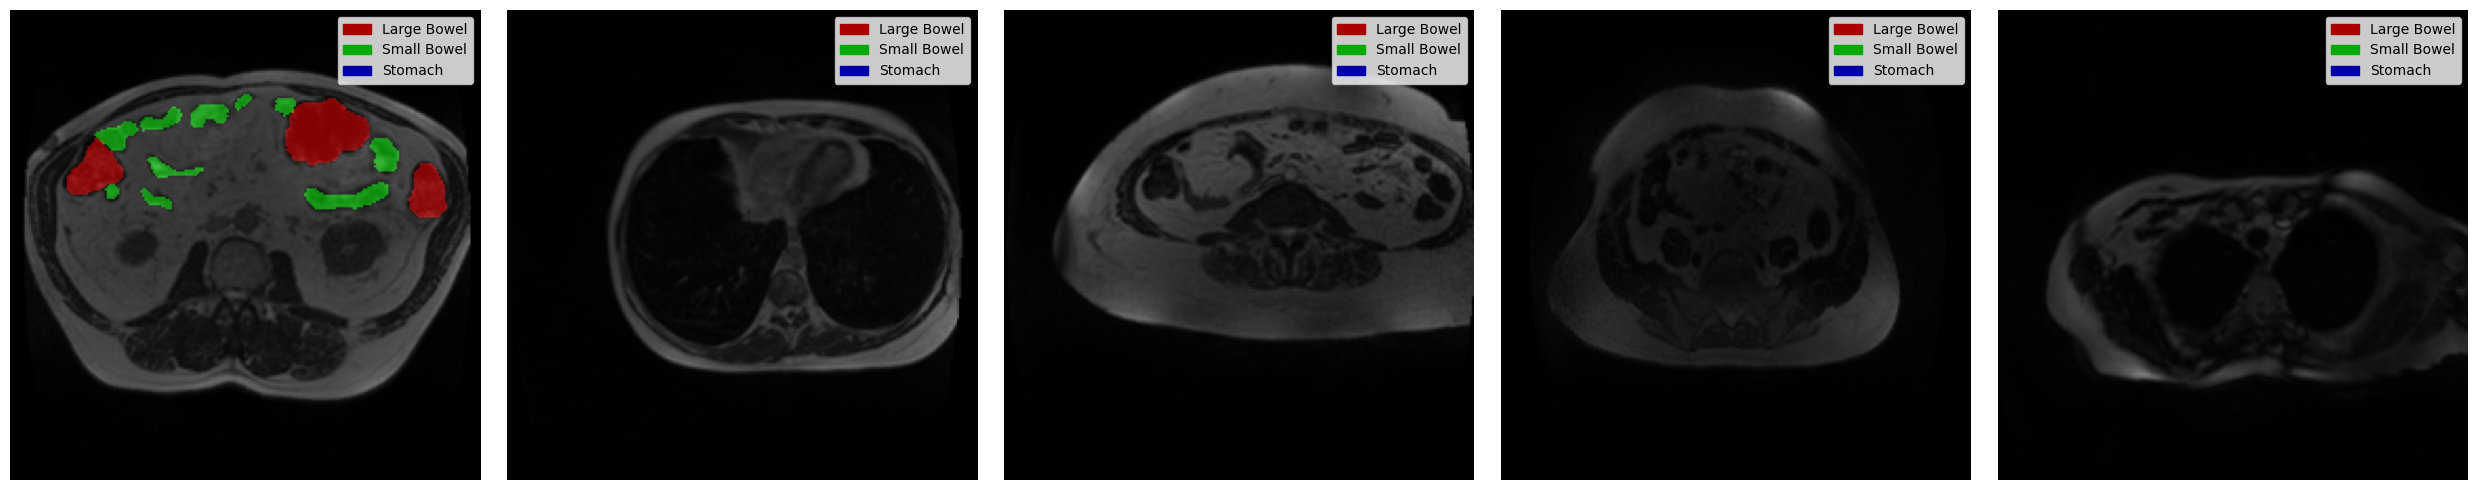

In [60]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

def group_plot(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

group_plot(imgs, msks, size=5)

# Model

## Unet

In [61]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 16 * n_channels)
        self.enc5 = Down(16 * n_channels, 16 * n_channels)

        self.dec1 = Up(32 * n_channels, 8 * n_channels)
        self.dec2 = Up(16 * n_channels, 4 * n_channels)
        self.dec3 = Up(8 * n_channels, 2 * n_channels)
        self.dec4 = Up(4 * n_channels, n_channels)
        self.dec5 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x6 = self.enc5(x5)

        mask = self.dec1(x6, x5)
        mask = self.dec2(mask, x4)
        mask = self.dec3(mask, x3)
        mask = self.dec4(mask, x2)
        mask = self.dec5(mask, x1)
        mask = self.out(mask)
        return mask

In [62]:
!pip install torchviz

In [64]:
from PIL import Image
from IPython.display import display

In [66]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
device

device(type='cpu')

In [81]:
def build_model():
    model = UNet(in_channels=3, n_classes=3, n_channels=48)
#     model = DeepLabV3Plus(num_classes=3)
    model.to(device)
    return model


def load_model(path, map_location=None):
    model = build_model()
    state_dict = torch.load(path, map_location=map_location)
    model.load_state_dict(state_dict)
    model.eval()
    return model

## Dice Score function


### Dice Score
The Dice Score (also known as the Sørensen-Dice coefficient) is a statistical measure that quantifies the similarity between two sets. In the context of image segmentation, it measures the overlap between the predicted segmentation and the ground truth.
`Dice = (2 * |A ∩ B|) / (|A| + |B|)` <br>
  where:
  - `|A|` is the total number of pixels in the predicted segmentation.
  - `|B|` is the total number of pixels in the ground truth.
  - `|A ∩ B|` is the number of pixels that are correctly predicted (the intersection).

### Jaccard Score
 The Jaccard Score (also known as the Intersection over Union, IoU) is another measure of similarity between two sets. It is also used in image segmentation tasks and measures the proportion of the intersection of the predicted segmentation and the ground truth to their union.
  `Jaccard = |A ∩ B| / |A ∪ B|`<br>
  where:
  - `|A ∪ B|` is the total number of unique pixels in either the predicted segmentation or the ground truth (the union).

The Dice Score and Jaccard Score are metrics commonly used to evaluate the performance of models in tasks involving image segmentation

In [69]:
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def mylossfn(y_pred, y_true):
    return 0.6*BCELoss(y_pred, y_true) + 0.4*DiceLoss(y_pred, y_true)

In [70]:
train_bs=32
n_accumulate=max(1, 32//train_bs)

In [71]:
epochs=5

lr_scheduler.CosineAnnealingLR: This is a learning rate scheduler that adjusts the learning rate according to a cosine annealing schedule. The idea is to decrease the learning rate in a cosine manner, starting from the initial learning rate and approaching a minimum value over time. This can help in achieving better convergence and escaping local minima

In [72]:
# Initialize model, optimizer, scheduler, and other parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(30000 / train_bs * epochs) + 50, eta_min=1e-6)

In [73]:
# Initialize variables for tracking best model
start = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_dice = -np.inf
best_epoch = -1
history = defaultdict(list)

In [74]:
if torch.cuda.is_available():
    print(f"Using CUDA: {torch.cuda.get_device_name()}\n")

In [75]:
# # Training and validation loop
# for epoch in range(1, epochs + 1):
#     gc.collect()
#     print(f'Epoch {epoch}/{epochs}')
#     # Training Phase
#     model.train()
#     scaler = amp.GradScaler()
#     dataset_size = 0
#     running_loss = 0.0
#     pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Train')

#     for step, (images, masks) in pbar:
#         images = images.to(device, dtype=torch.float)
#         masks = masks.to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         with amp.autocast(enabled=True):
#             y_pred = model(images)
#             loss = mylossfn(y_pred, masks) / n_accumulate

#         scaler.scale(loss).backward()

#         if (step + 1) % n_accumulate == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#             if scheduler is not None:
#                 scheduler.step()

#         running_loss += loss.item() * batch_size
#         dataset_size += batch_size
#         epoch_loss = running_loss / dataset_size

#         mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
#         current_lr = optimizer.param_groups[0]['lr']
#         pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', gpu_mem=f'{mem:0.2f} GB')

#     history['Train Loss'].append(epoch_loss)

#     # Validation Phase
#     model.eval()
#     dataset_size = 0
#     running_loss = 0.0
#     val_scores = []
#     pbar = tqdm(enumerate(validation_loader), total=len(validation_loader), desc='Valid')

#     for step, (images, masks) in pbar:
#         images = images.to(device, dtype=torch.float)
#         masks = masks.to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         with torch.no_grad():
#             y_pred = model(images)
#             loss = mylossfn(y_pred, masks)

#         running_loss += loss.item() * batch_size
#         dataset_size += batch_size
#         epoch_loss = running_loss / dataset_size

#         y_pred = torch.sigmoid(y_pred)
#         val_dice = dice_coef(masks, y_pred).cpu().numpy()
#         val_jaccard = iou_coef(masks, y_pred).cpu().numpy()
#         val_scores.append([val_dice, val_jaccard])

#         mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
#         current_lr = optimizer.param_groups[0]['lr']
#         pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', gpu_memory=f'{mem:0.2f} GB')

#     val_dice, val_jaccard = np.mean(val_scores, axis=0)
#     history['Valid Loss'].append(epoch_loss)
#     history['Valid Dice'].append(val_dice)
#     history['Valid Jaccard'].append(val_jaccard)

#     print(f'Validation Results - Dice: {val_dice:.4f} | Jaccard: {val_jaccard:.4f}')

#     # Save the best model
#     if val_dice >= best_dice:
#         print(f"Improved Dice Score from {best_dice:.4f} to {val_dice:.4f}")
#         best_dice = val_dice
#         best_jaccard = val_jaccard
#         best_epoch = epoch
#         best_model_wts = copy.deepcopy(model.state_dict())
#         torch.save(best_model_wts, f"best_epoch-{fold:02d}.bin")
#         print("Best model saved.")

#     # Save the model at the end of each epoch
#     torch.save(model.state_dict(), f"last_epoch-{fold:02d}.bin")
#     print("Last model saved.\n")

# # Training duration and best scores
# end = time.time()
# time_elapsed = end - start
# print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
# print("Best Dice Score: {:.4f} | Best Jaccard Score: {:.4f}".format(best_dice, best_jaccard))

# # Load the best model weights
# model.load_state_dict(best_model_wts)

In [76]:
# best_model_wts

test_dataset = myDataset(train_df[train_df.index.isin(validation_ids)], transforms=validation_transform)
test_loader  = DataLoader(test_dataset, batch_size=3, num_workers=4, shuffle=True, pin_memory=True)

imgs, msks =  next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float)

In [82]:
preds = []
for fold in range(1):
    model = load_model("/content/drive/My Drive/STAT5243/Project 3/Model/best_epoch-05.bin",  map_location=torch.device('cpu'))
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

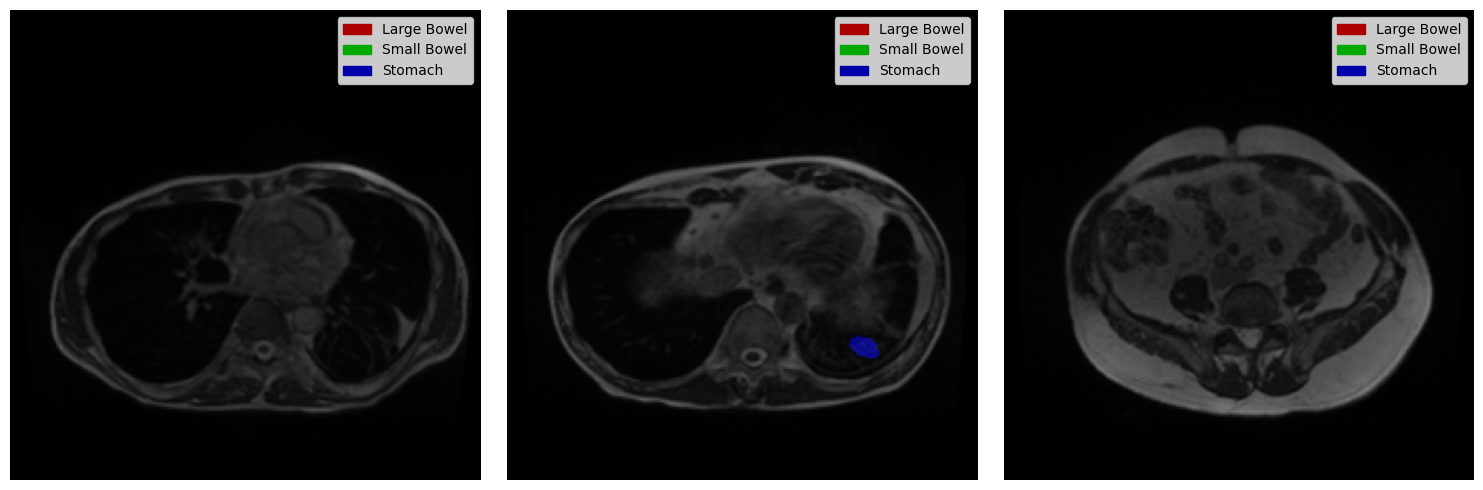

In [83]:
group_plot(imgs, preds, size=3)

Saving model

In [84]:
import torch
# Save both model state dict and entire model
torch.save({
    'model_state_dict': model.state_dict(),
    'model': model
}, "model_unet.pth")


In [85]:
# Load both model state dict and entire model
checkpoint = torch.load("model_unet.pth")
model = checkpoint['model']         # Loads the entire model
model.load_state_dict(checkpoint['model_state_dict'])  # Loads the model's state dict

model.eval()  # Set to evaluation mode if needed

UNet(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [86]:
# Load the image as a grayscale and then repeat the channel to make it 3-channel
# image = Image.open("../input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png").convert('L')
# image = Image.open("/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0077_266_266_1.50_1.50.png").convert('L')
image = Image.open(train_df['path'].loc[29]).convert('L')

image = TF.to_tensor(image).to(torch.float32)  # Convert to tensor and float32
image = image.repeat(3, 1, 1)  # Duplicate the channel to get 3 channels
image = image.unsqueeze(0)  # Add batch dimension if needed

In [88]:
def segment(image, model):
    with torch.inference_mode():
        prediction = model(image)
    return torch.sigmoid(prediction).cpu()

In [89]:
model1=model

Text(0.5, 1.0, 'Unet Model')

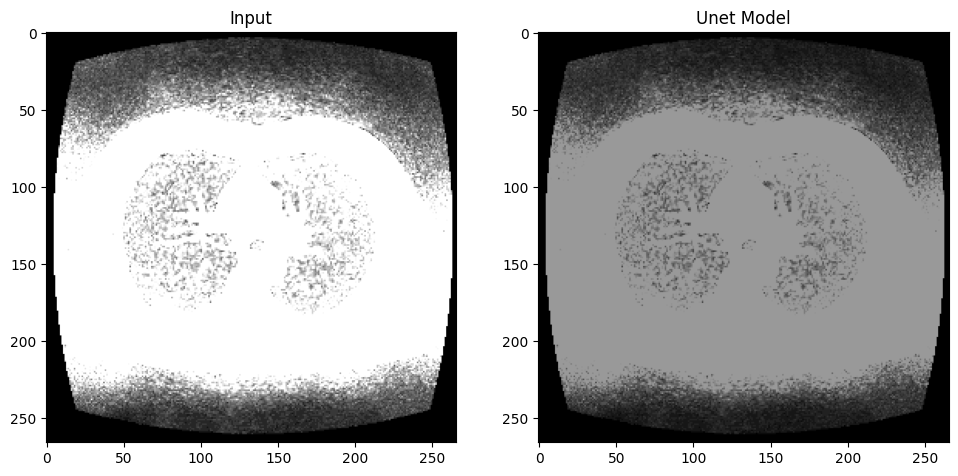

In [90]:
output = segment(image.to(device), model1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(image[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.4);
plt.title('Unet Model')

## DeepLabV3Plus

In [91]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, 1, padding=0, dilation=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)

        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.conv_1x1_output(x)
        return x

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.aspp = ASPP(2048, 256)

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.aspp(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        x = self.decoder(x)
        return x


In [ ]:
# # Create a dummy input tensor
# x = torch.randn(1, 3, 224, 224)  # Example input
# # Define the U-Net model
# model = DeepLabV3Plus(num_classes=3)
# # Forward pass
# y = model(x)
# # Generate the computation graph
# make_dot(y, params=dict(model.named_parameters())).render("DeepLabV3Plus", format="png")

In [ ]:
# img = Image.open("unet_architecture.png")
# display(img)

In [92]:
def build_model():
    # model = UNet(in_channels=3, n_classes=3, n_channels=48)
    model = DeepLabV3Plus(num_classes=3)
    model.to(device)
    return model

In [93]:
# Initialize model, optimizer, scheduler, and other parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(30000 / train_bs * epochs) + 50, eta_min=1e-6)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.6MB/s]


In [94]:
# Initialize variables for tracking best model
start = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_dice = -np.inf
best_epoch = -1
history = defaultdict(list)

In [95]:
if torch.cuda.is_available():
    print(f"Using CUDA: {torch.cuda.get_device_name()}\n")

In [97]:
# # Training and validation loop
# for epoch in range(1, epochs + 1):
#     gc.collect()
#     print(f'Epoch {epoch}/{epochs}')
#     # Training Phase
#     model.train()
#     scaler = amp.GradScaler()
#     dataset_size = 0
#     running_loss = 0.0
#     pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Train')

#     for step, (images, masks) in pbar:
#         images = images.to(device, dtype=torch.float)
#         masks = masks.to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         with amp.autocast(enabled=True):
#             y_pred = model(images)
#             # loss = mylossfn(y_pred, masks) / n_accumulate
#             # Resize y_pred to match masks shape
#             y_pred_resized = F.interpolate(y_pred, size=(224, 224), mode='bilinear', align_corners=False)
#             loss = mylossfn(y_pred_resized, masks) / n_accumulate

#         scaler.scale(loss).backward()

#         if (step + 1) % n_accumulate == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#             if scheduler is not None:
#                 scheduler.step()

#         running_loss += loss.item() * batch_size
#         dataset_size += batch_size
#         epoch_loss = running_loss / dataset_size

#         mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
#         current_lr = optimizer.param_groups[0]['lr']
#         pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', gpu_mem=f'{mem:0.2f} GB')

#     history['Train Loss'].append(epoch_loss)

#     # Validation Phase
#     model.eval()
#     dataset_size = 0
#     running_loss = 0.0
#     val_scores = []
#     pbar = tqdm(enumerate(validation_loader), total=len(validation_loader), desc='Valid')

#     for step, (images, masks) in pbar:
#         images = images.to(device, dtype=torch.float)
#         masks = masks.to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         with torch.no_grad():
#             y_pred = model(images)
#             y_pred_resized = F.interpolate(y_pred, size=(224, 224), mode='bilinear', align_corners=False)
#             loss = mylossfn(y_pred_resized, masks)

#         running_loss += loss.item() * batch_size
#         dataset_size += batch_size
#         epoch_loss = running_loss / dataset_size

#         y_pred = torch.sigmoid(y_pred)
#         val_dice = dice_coef(masks, y_pred_resized).cpu().numpy()
#         val_jaccard = iou_coef(masks, y_pred_resized).cpu().numpy()
#         val_scores.append([val_dice, val_jaccard])

#         mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
#         current_lr = optimizer.param_groups[0]['lr']
#         pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}', lr=f'{current_lr:0.5f}', gpu_memory=f'{mem:0.2f} GB')

#     val_dice, val_jaccard = np.mean(val_scores, axis=0)
#     history['Valid Loss'].append(epoch_loss)
#     history['Valid Dice'].append(val_dice)
#     history['Valid Jaccard'].append(val_jaccard)

#     print(f'Validation Results - Dice: {val_dice:.4f} | Jaccard: {val_jaccard:.4f}')

#     # Save the best model
#     if val_dice >= best_dice:
#         print(f"Improved Dice Score from {best_dice:.4f} to {val_dice:.4f}")
#         best_dice = val_dice
#         best_jaccard = val_jaccard
#         best_epoch = epoch
#         best_model_wts = copy.deepcopy(model.state_dict())
#         torch.save(best_model_wts, f"best_epochdeeplab-{fold:02d}.bin")
#         print("Best model saved.")

#     # Save the model at the end of each epoch
#     torch.save(model.state_dict(), f"last_epochdeeplab-{fold:02d}.bin")
#     print("Last model saved.\n")

# # Training duration and best scores
# end = time.time()
# time_elapsed = end - start
# print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
# print("Best Dice Score: {:.4f} | Best Jaccard Score: {:.4f}".format(best_dice, best_jaccard))

# # Load the best model weights
# model.load_state_dict(best_model_wts)

In [102]:
# best_model_wts

In [99]:
test_dataset = myDataset(train_df[train_df.index.isin(validation_ids)], transforms=validation_transform)
test_loader  = DataLoader(test_dataset, batch_size=3, num_workers=4, shuffle=True, pin_memory=True)

In [100]:
imgs, msks =  next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float)

In [103]:
preds = []
model = load_model("/content/drive/My Drive/STAT5243/Project 3/Model/best_epochdeeplab-00.bin", map_location=torch.device('cpu'))
with torch.no_grad():
    pred = model(imgs)
    pred = (nn.Sigmoid()(pred)>0.5).double()
preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

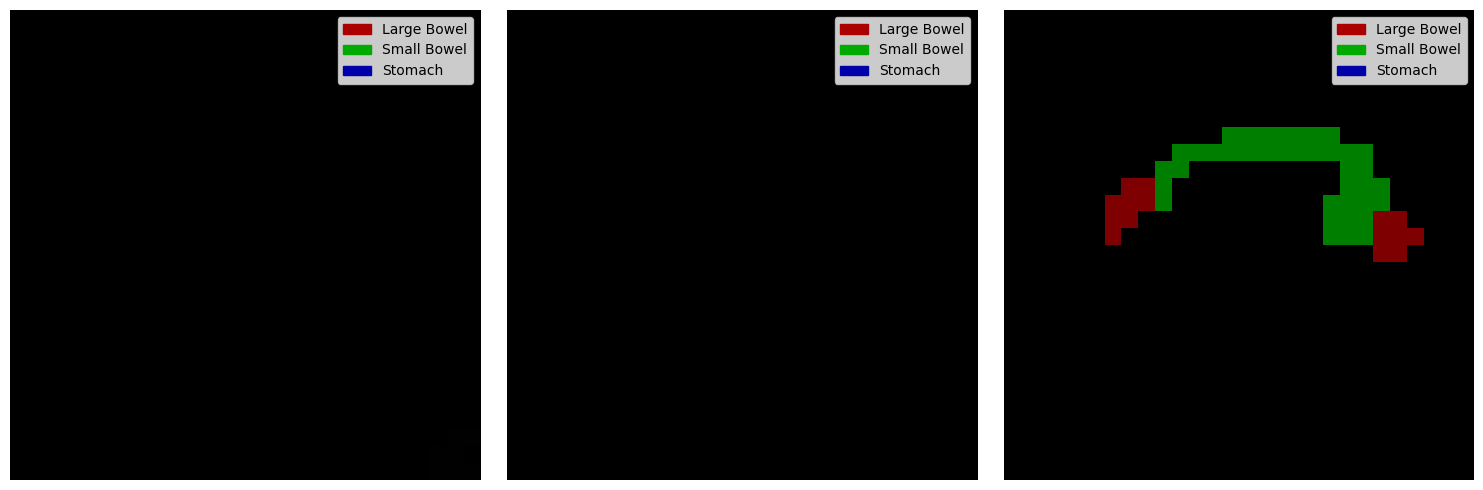

In [104]:
group_plot(imgs, preds, size=3)